# Image-Generation-Finetuning

## Install dependencies

In [3]:
!pip install -qq diffusers datasets accelerate

In [2]:
!pip install -r requirements.txt

In [1]:
from diffusers import StableDiffusionPipeline, DDPMScheduler
from diffusers import UNet2DConditionModel, AutoencoderKL, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from datasets import load_dataset
from accelerate import Accelerator
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

## Stable Diffusion model initialization from HuggingFace

In [2]:
pretrained_model = "CompVis/stable-diffusion-v1-4"
device = "cpu"

pipe = StableDiffusionPipeline.from_pretrained(pretrained_model).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

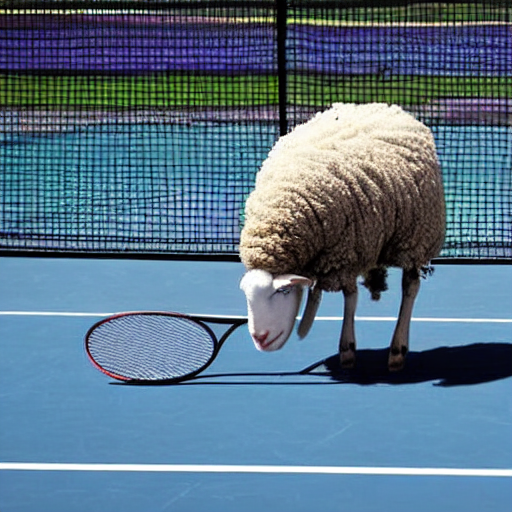

In [5]:
prompt = "an image of a sheep playing tennis with a racket"
image = pipe(prompt).images[0]

image

## Model Finetuning

For this project we will be uploading only the training part of the images from the dataset *[oldbookillustrations](https://huggingface.co/datasets/gigant/oldbookillustrations)*. This is done to reduce training time, less memory and disk consumption and to be more manageable to experiment our finetuning.

In [4]:
train_dataset = load_dataset("gigant/oldbookillustrations", split="train[:300]")

print(train_dataset)


Generating train split:   0%|          | 0/4154 [00:00<?, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [ ]:

size = train_dataset[0]["image"].size
print(f"Tamaño de las imagenes del dataset: {size}")